<a href="https://colab.research.google.com/github/Phung-Thu-Trang/Group8-final-project/blob/trang/visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Cài đặt PySpark nếu chưa có
!pip install pyspark
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date
from pyspark.sql.functions import col, mean, stddev, when, count
!pip install ta
from ta.trend import MACD, SMAIndicator
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import BollingerBands
from ta import add_all_ta_features



In [27]:
# Khởi tạo SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("IBM Stock Data") \
    .getOrCreate()


In [28]:
df_clean=spark.read.csv("/content/sample_data/IBM_clean.csv", header=True, inferSchema=True)
df_clean.show(5)

+----------+------+------+------+------+------+
|      date|  open|  high|   low| close|volume|
+----------+------+------+------+------+------+
|1962-01-02|1.5364|1.5364|1.5191|1.5191|  4063|
|1962-01-03|1.5191|1.5324|1.5191|1.5324|  3047|
|1962-01-04|1.5324|1.5324|1.5164|1.5171|  2735|
|1962-01-05|1.5151|1.5151|1.4845|1.4872|  3828|
|1962-01-08|1.4859|1.4859|1.4474|1.4593|  5703|
+----------+------+------+------+------+------+
only showing top 5 rows



In [29]:
df_pd = df_clean.select("Date", "Close").orderBy("Date").toPandas()



In [30]:
#df_pd["Date"] = pd.to_datetime(df_pd["Date"])
#df_pd.set_index("Date", inplace=True)


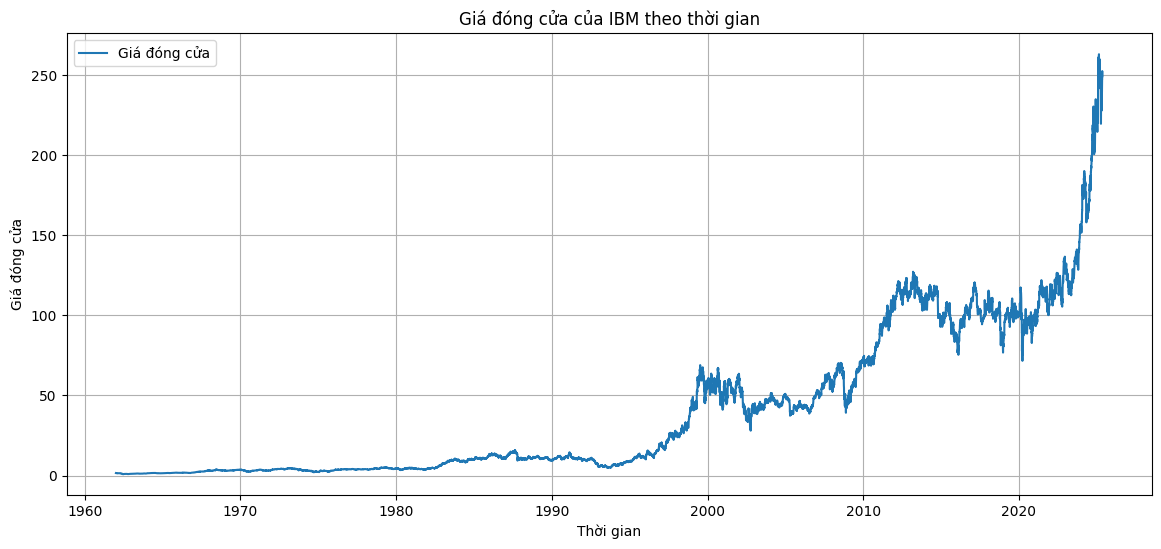

In [31]:
import matplotlib.pyplot as plt
# Convert the PySpark DataFrame to a Pandas DataFrame
#df_pd_pandas = df_pd.toPandas()

plt.figure(figsize=(14, 6))
# Access the columns using Pandas syntax
# Use df_pd.index to access the dates (which are now the index)
plt.plot(df_pd.index, df_pd["Close"], label='Giá đóng cửa')
plt.title("Giá đóng cửa của IBM theo thời gian")
plt.xlabel("Thời gian")
plt.ylabel("Giá đóng cửa")
plt.grid(True)
plt.legend()
plt.show()

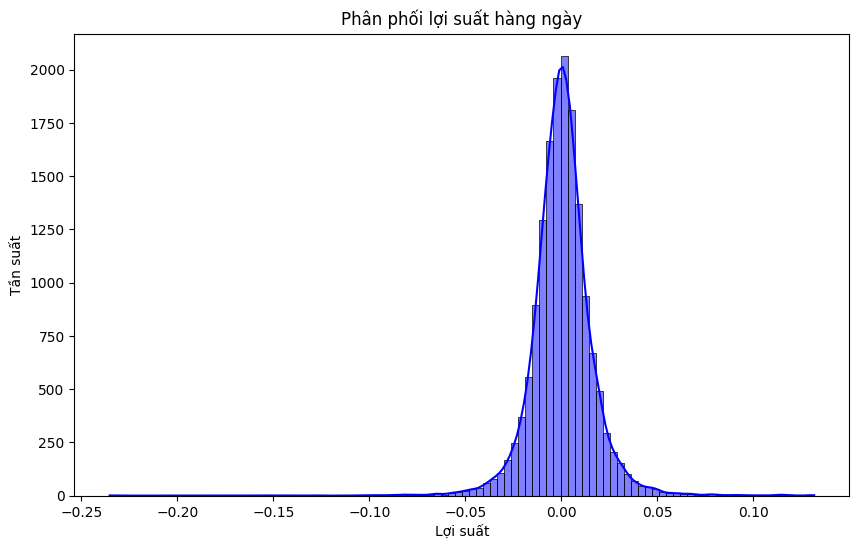

In [32]:
#Tính lợi suất hàng ngày
df_pd["Daily Return"] = df_pd["Close"].pct_change()

plt.figure(figsize=(10,6))
sns.histplot(df_pd["Daily Return"].dropna(), bins=100, color="blue", kde=True)
plt.title("Phân phối lợi suất hàng ngày")
plt.xlabel("Lợi suất")
plt.ylabel("Tần suất")
plt.show()


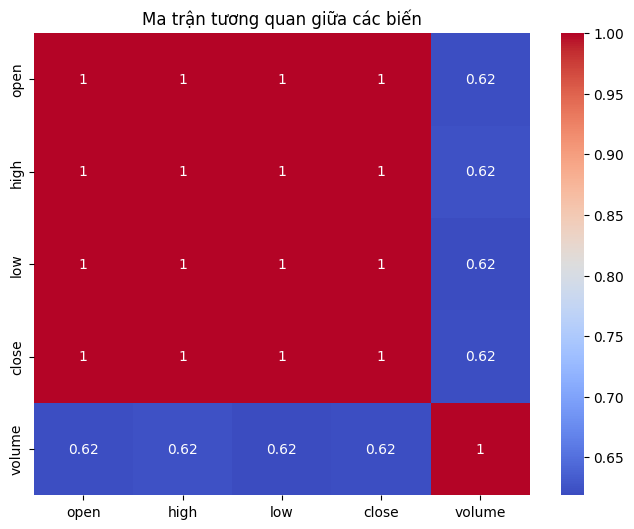

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_clean still contains all the original columns
df_corr = df_clean.select("open", "high", "low", "close", "volume").toPandas()

plt.figure(figsize=(8,6))
sns.heatmap(
    df_corr.corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Ma trận tương quan giữa các biến")
plt.show()

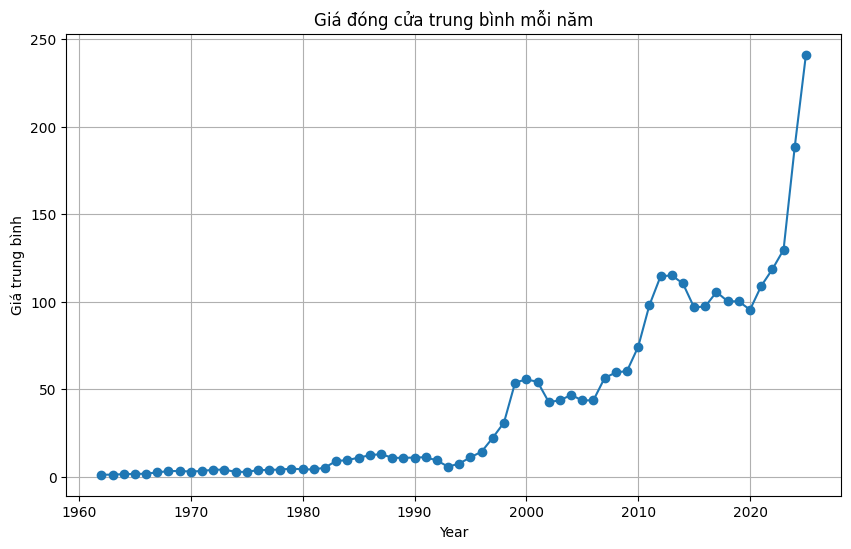

In [34]:
# Thêm các cột thời gian
df_pd["Year"] = df_pd.index.year
df_pd["Month"] = df_pd.index.month

# Giá trung bình mỗi năm
plt.figure(figsize=(10,6))
df_pd.groupby("Year")["Close"].mean().plot(marker='o')
plt.title("Giá đóng cửa trung bình mỗi năm")
plt.ylabel("Giá trung bình")
plt.grid(True)
plt.show()

# Khối lượng trung bình theo tháng
# Include 'Volume' when selecting columns for the pandas DataFrame
df_pd_with_volume = df_clean.select("Date", "Close", "volume").orderBy("Date").toPandas()  # Include 'volume' here
df_pd_with_volume["Date"] = pd.to_datetime(df_pd_with_volume["Date"])
df_pd_with_volume.set_index("Date", inplace=True)
df_pd_with_volume["Year"] = df_pd_with_volume.index.year
df_pd_with_volume["Month"] = df_pd_with_volume.index.month



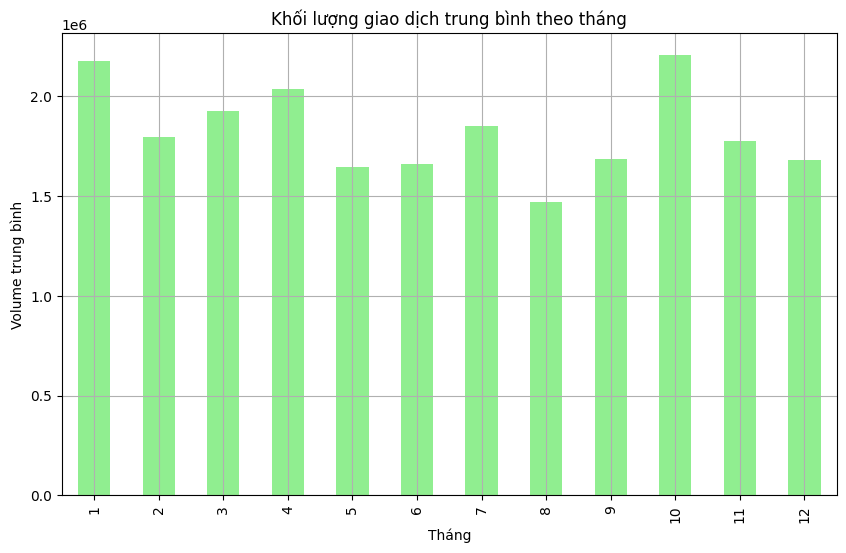

In [35]:
plt.figure(figsize=(10,6))
# Now you can use 'Volume' for the plot
df_pd_with_volume.groupby("Month")["volume"].mean().plot(kind='bar', color='lightgreen')
plt.title("Khối lượng giao dịch trung bình theo tháng")
plt.xlabel("Tháng")
plt.ylabel("Volume trung bình")
plt.grid(True)
plt.show()

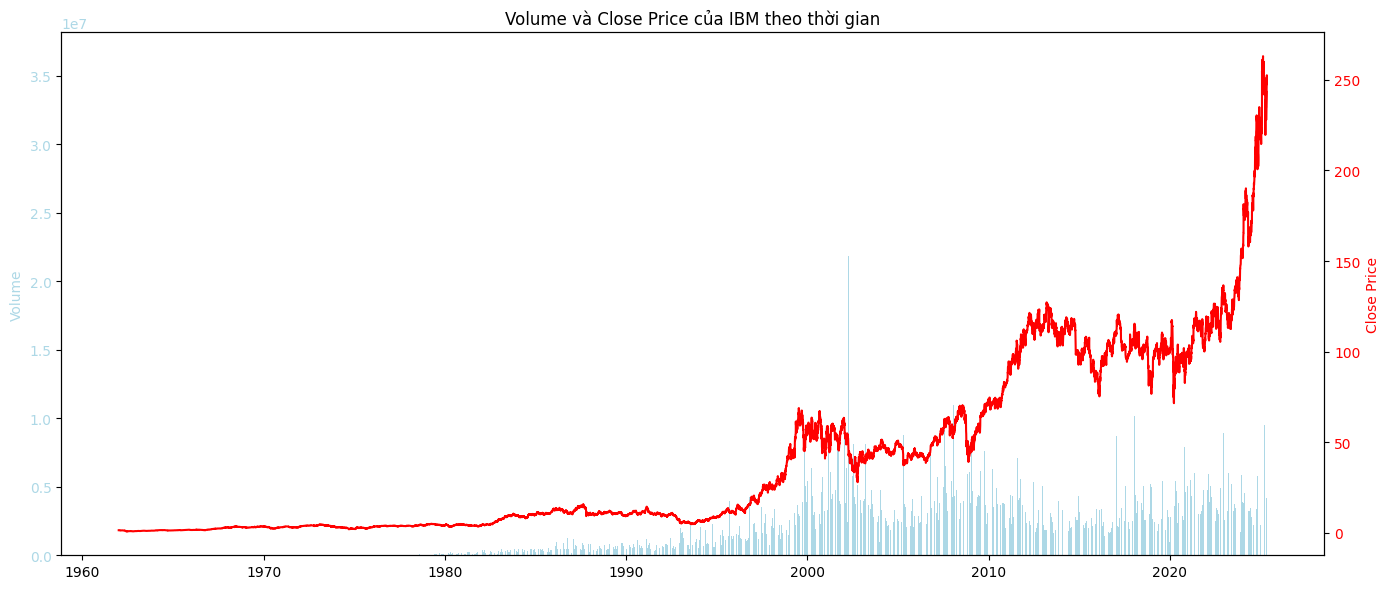

In [36]:
import matplotlib.pyplot as plt


# Vẽ biểu đồ volume và close price
fig, ax1 = plt.subplots(figsize=(14,6))

# Vẽ khối lượng giao dịch bằng biểu đồ cột
# Use df_pd_with_volume which contains the 'volume' column
ax1.bar(df_pd_with_volume.index, df_pd_with_volume['volume'], color='lightblue', label='Volume')
ax1.set_ylabel('Volume', color='lightblue')
ax1.tick_params(axis='y', labelcolor='lightblue')

# Vẽ giá đóng cửa bằng đường line trên trục y phụ
ax2 = ax1.twinx()
# Use df_pd_with_volume for consistent indexing, although df_pd also has 'close'
ax2.plot(df_pd_with_volume.index, df_pd_with_volume['Close'], color='red', label='Close Price')
ax2.set_ylabel('Close Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Tiêu đề và định dạng
plt.title("Volume và Close Price của IBM theo thời gian")
fig.tight_layout()
plt.show()

In [37]:
#Ngày biến động mạnh nhất
print("Top 5 ngày có lợi suất lớn nhất:")
print(df_pd.sort_values("Daily Return", ascending=False)[["Close", "Daily Return"]].head())

print("\nTop 5 ngày có lợi suất âm lớn nhất:")
print(df_pd.sort_values("Daily Return", ascending=True)[["Close", "Daily Return"]].head())


Top 5 ngày có lợi suất lớn nhất:
               Close  Daily Return
Date                              
1999-04-22   48.5591      0.131637
2025-01-30  254.8650      0.129641
1996-07-25   12.6432      0.129432
2001-01-18   54.5218      0.120232
1994-04-21    6.9252      0.117220

Top 5 ngày có lợi suất âm lớn nhất:
              Close  Daily Return
Date                             
1987-10-19   9.3021     -0.235188
2000-10-18  47.9798     -0.155421
1999-10-21  45.5341     -0.149534
2020-03-12  77.6677     -0.128507
1992-12-15   6.4184     -0.107353


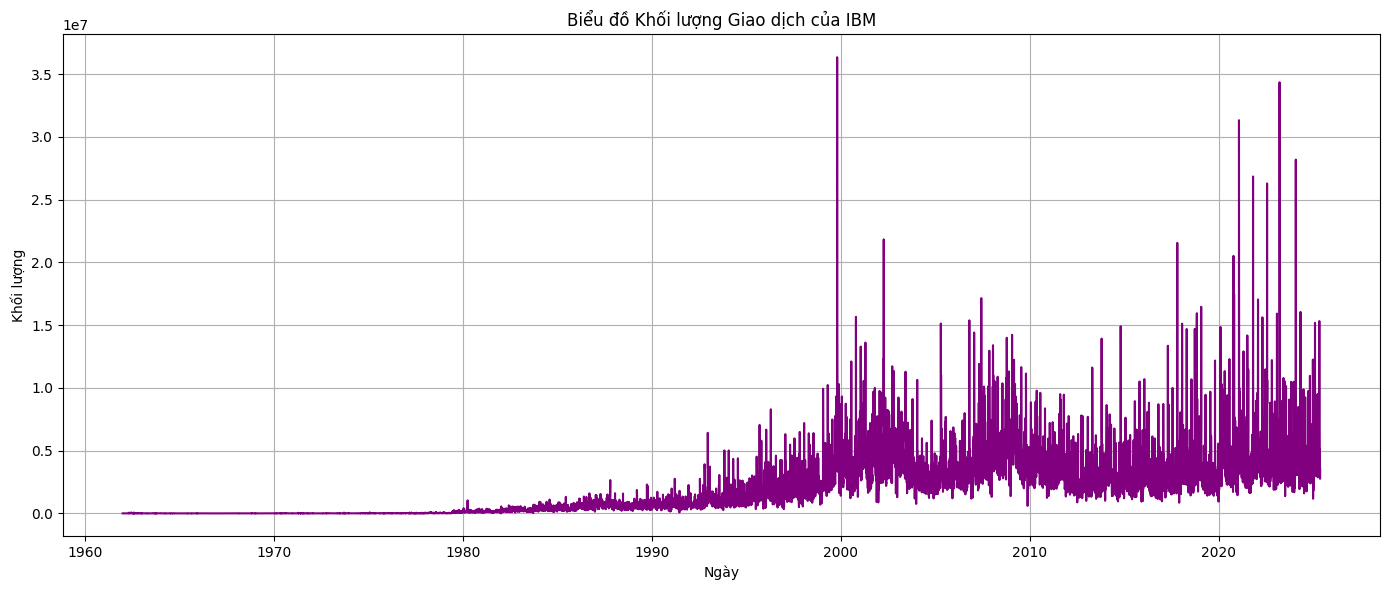

In [38]:
plt.figure(figsize=(14, 6))
plt.plot(df_pd_with_volume.index, df_pd_with_volume['volume'], color='purple')  # Use index for date and 'volume' column
plt.title("Biểu đồ Khối lượng Giao dịch của IBM")
plt.xlabel("Ngày")
plt.ylabel("Khối lượng")
plt.grid(True)
plt.tight_layout()
plt.show()

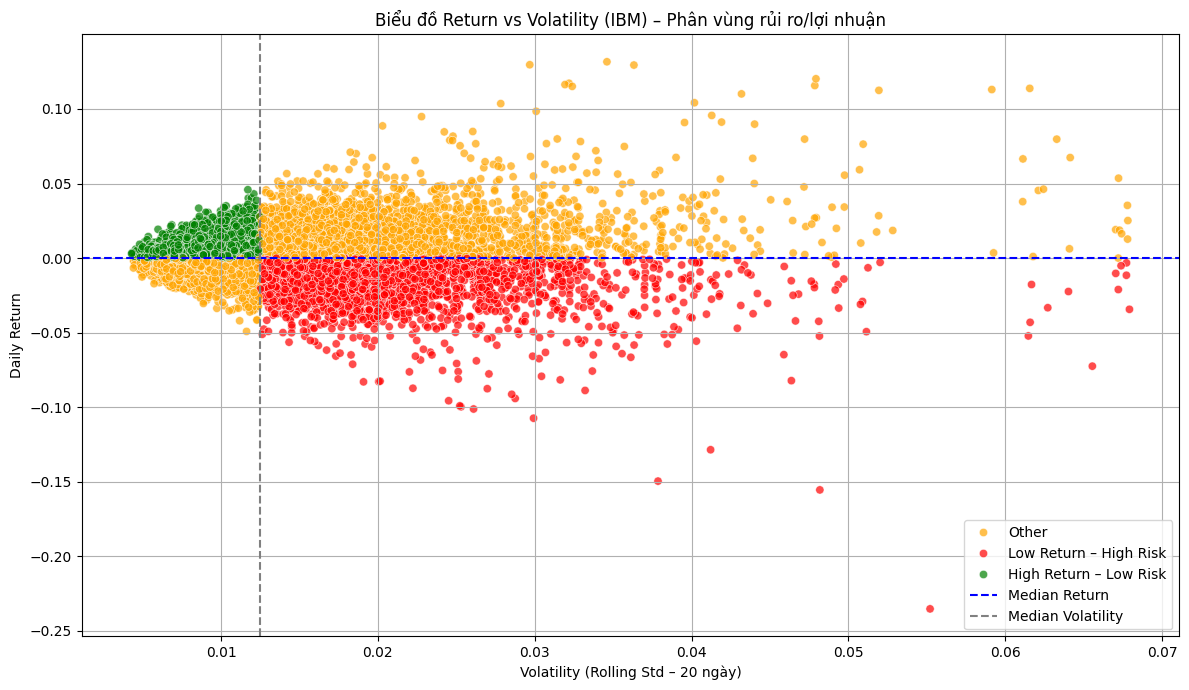

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F # Keep import for potential PySpark use later if needed
from pyspark.sql.window import Window # Keep import for potential PySpark use later if needed

# Ensure df_pd is created with all necessary columns and converted to pandas once.
# We will use the df_clean PySpark DataFrame as the source,
# which should already have columns like 'date', 'open', 'high', 'low', 'close', 'volume'.
# Select all the columns you will need for subsequent analysis before converting.
# Based on your plots, you need 'date', 'close', 'volume', 'high', 'low'.
df_pd = df_clean.select("date", "open", "high", "low", "close", "volume").orderBy("date").toPandas()

# Convert the date column to datetime and set it as the index
df_pd["date"] = pd.to_datetime(df_pd["date"])
df_pd.set_index("date", inplace=True)

# Ensure the index is sorted by date
df_pd = df_pd.sort_index()

# Now proceed with calculations using the df_pd pandas DataFrame

# Calculate daily return using pandas pct_change
df_pd['daily_return'] = df_pd['close'].pct_change()

# Calculate volatility using pandas rolling and std
# Ensure the window size (20) is less than or equal to the number of data points
df_pd['volatility'] = df_pd['daily_return'].rolling(window=20).std()

# Loại bỏ NaN
df_plot_pd = df_pd[['daily_return', 'volatility']].dropna()

# Tính trung vị để phân vùng using pandas median
return_median = df_plot_pd['daily_return'].median()
vol_median = df_plot_pd['volatility'].median()

# Tạo cột phân vùng using pandas numpy.select
conditions = [
    (df_plot_pd['daily_return'] >= return_median) & (df_plot_pd['volatility'] < vol_median),
    (df_plot_pd['daily_return'] < return_median) & (df_plot_pd['volatility'] >= vol_median),
]
choices = ['High Return – Low Risk', 'Low Return – High Risk']
# Default is 'Other' for cases that don't fit the specific high/low criteria
df_plot_pd['zone'] = np.select(conditions, choices, default='Other')

# Vẽ biểu đồ với màu theo vùng
plt.figure(figsize=(12, 7))
palette = {'High Return – Low Risk': 'green',
           'Low Return – High Risk': 'red',
           'Other': 'orange'} # Include 'Other' in the palette

sns.scatterplot(data=df_plot_pd, x='volatility', y='daily_return', hue='zone', palette=palette, alpha=0.7)
plt.axhline(return_median, color='blue', linestyle='--', label='Median Return')
plt.axvline(vol_median, color='gray', linestyle='--', label='Median Volatility')

plt.title("Biểu đồ Return vs Volatility (IBM) – Phân vùng rủi ro/lợi nhuận")
plt.xlabel("Volatility (Rolling Std – 20 ngày)")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

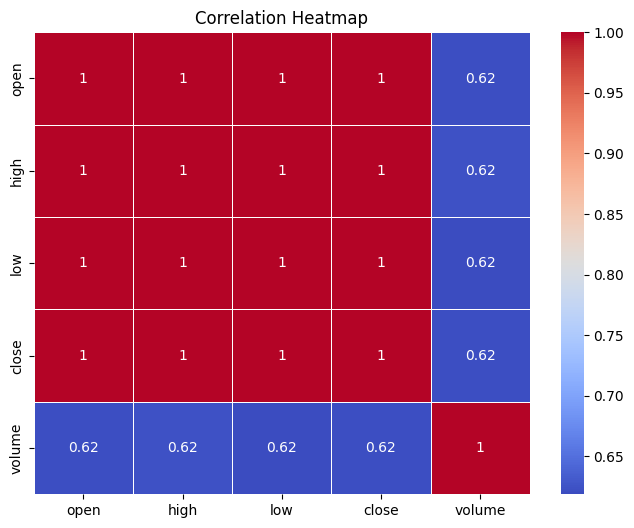

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_clean still contains all the original columns
df_corr = df_clean.select("open", "high", "low", "close", "volume").toPandas()

plt.figure(figsize=(8,6))
sns.heatmap(
    df_corr.corr(),
    annot=True,
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation Heatmap")
plt.show()

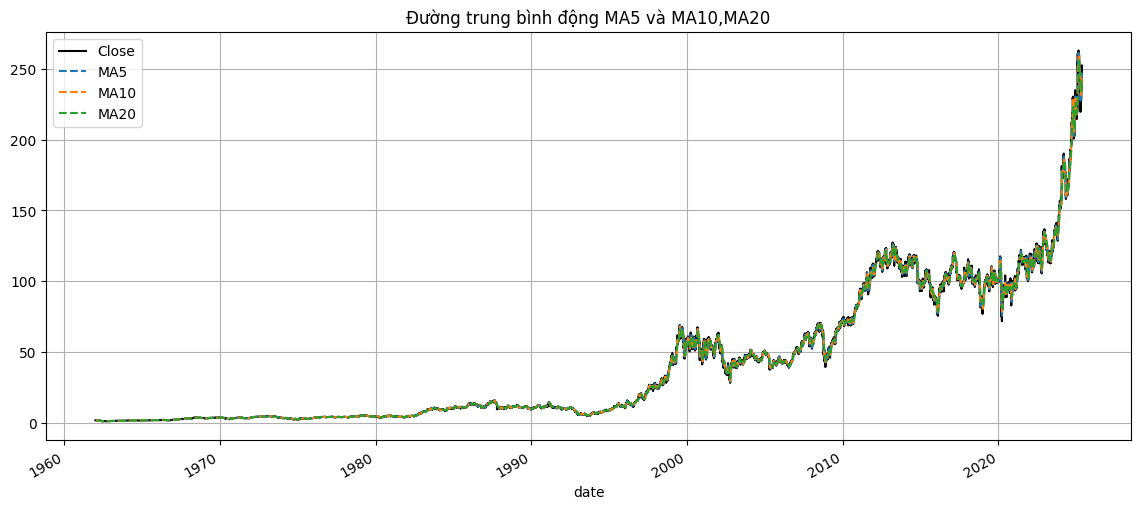

In [50]:
df_pd['MA5'] = df_pd['close'].rolling(window=5).mean() # Changed df to df_pd
df_pd['MA10'] = df_pd['close'].rolling(window=10).mean() # Changed df to df_pd
df_pd['MA20'] = df_pd['close'].rolling(window=20).mean()

plt.figure(figsize=(14,6))
df_pd['close'].plot(label='Close', color='black')
df_pd['MA5'].plot(label='MA5', linestyle='--')
df_pd['MA10'].plot(label='MA10', linestyle='--')
df_pd['MA20'].plot(label='MA20', linestyle='--')
plt.title("Đường trung bình động MA5 và MA10,MA20")
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# RSI
df_pd['RSI'] = RSIIndicator(close=df_pd['close'], window=14).rsi()

# MACD
macd = MACD(close=df_pd['close'], window_slow=26, window_fast=12, window_sign=9)
df_pd['MACD'] = macd.macd()
df_pd['MACD_signal'] = macd.macd_signal()

# Bollinger Bands
bb = BollingerBands(close=df_pd['close'], window=20, window_dev=2)
df_pd['bb_upper'] = bb.bollinger_hband()
df_pd['bb_lower'] = bb.bollinger_lband()
df_pd['bb_middle'] = bb.bollinger_mavg()

# Stochastic Oscillator
stoch = StochasticOscillator(high=df_pd['high'], low=df_pd['low'], close=df_pd['close'], window=14, smooth_window=3)
df_pd['stoch_k'] = stoch.stoch()
df_pd['stoch_d'] = stoch.stoch_signal()


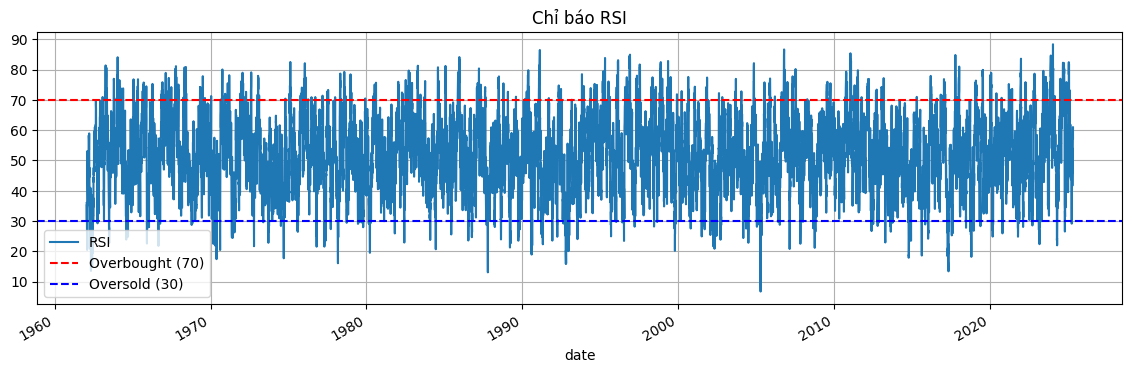

In [53]:
#RSI (Relative Strength Index)
plt.figure(figsize=(14,4))
df_pd['RSI'].plot()
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='blue', linestyle='--', label='Oversold (30)')
plt.title("Chỉ báo RSI")
plt.legend()
plt.grid(True)
plt.show()


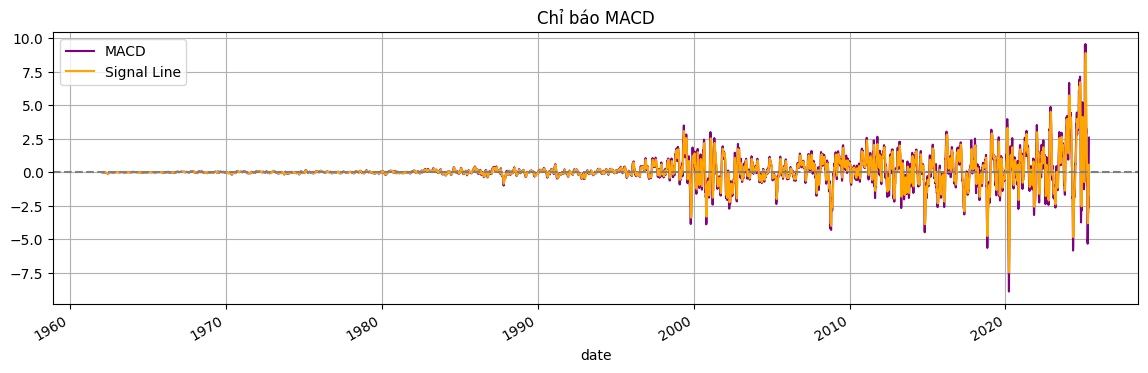

In [54]:
#MACD
plt.figure(figsize=(14,4))
df_pd['MACD'].plot(label='MACD', color='purple')
df_pd['MACD_signal'].plot(label='Signal Line', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Chỉ báo MACD")
plt.legend()
plt.grid(True)
plt.show()


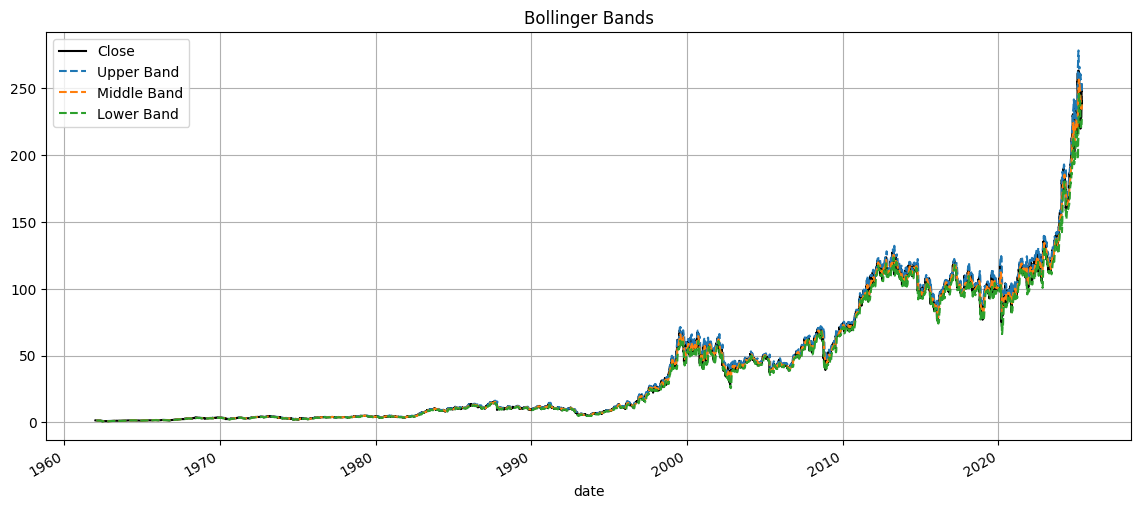

In [55]:
# Bollinger Bands
plt.figure(figsize=(14,6))
df_pd['close'].plot(label='Close', color='black')
df_pd['bb_upper'].plot(label='Upper Band', linestyle='--')
df_pd['bb_middle'].plot(label='Middle Band', linestyle='--')
df_pd['bb_lower'].plot(label='Lower Band', linestyle='--')
plt.title("Bollinger Bands")
plt.legend()
plt.grid(True)
plt.show()


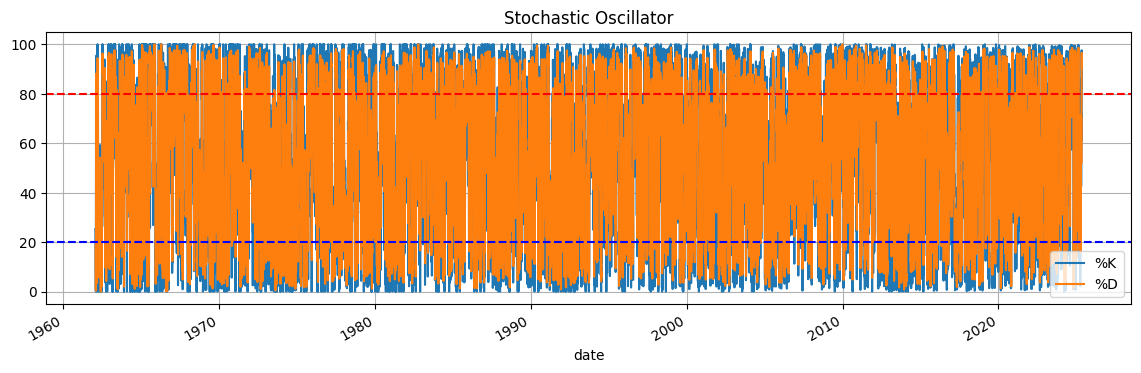

In [56]:
plt.figure(figsize=(14,4))
df_pd['stoch_k'].plot(label='%K')
df_pd['stoch_d'].plot(label='%D')
plt.axhline(80, color='red', linestyle='--')
plt.axhline(20, color='blue', linestyle='--')
plt.title("Stochastic Oscillator")
plt.legend()
plt.grid(True)
plt.show()


In [57]:
def calculate_parabolic_sar(high, low, af=0.02, max_af=0.2):
    """
    Tính Parabolic SAR theo công thức thủ công.
    high, low: Series giá cao và thấp
    af: acceleration factor
    max_af: giới hạn trên của af
    """
    sar = [low.iloc[0]]  # Khởi tạo SAR đầu tiên
    ep = high.iloc[0]    # Extreme Point
    trend = 1            # 1: uptrend, -1: downtrend
    af_current = af

    for i in range(1, len(high)):
        prev_sar = sar[-1]

        # SAR tiếp theo
        new_sar = prev_sar + af_current * (ep - prev_sar)

        # Giới hạn SAR không được vượt quá giá của 2 phiên trước
        if trend == 1:
            new_sar = min(new_sar, low.iloc[i-1], low.iloc[i])
        else:
            new_sar = max(new_sar, high.iloc[i-1], high.iloc[i])

        # Xác định xu hướng
        reverse = False
        if trend == 1:
            if low.iloc[i] < new_sar:
                trend = -1
                reverse = True
                ep = low.iloc[i]
                af_current = af
                new_sar = ep
        else:
            if high.iloc[i] > new_sar:
                trend = 1
                reverse = True
                ep = high.iloc[i]
                af_current = af
                new_sar = ep

        if not reverse:
            if trend == 1:
                if high.iloc[i] > ep:
                    ep = high.iloc[i]
                    af_current = min(af_current + af, max_af)
            else:
                if low.iloc[i] < ep:
                    ep = low.iloc[i]
                    af_current = min(af_current + af, max_af)

        sar.append(new_sar)

    return pd.Series(sar, index=high.index)


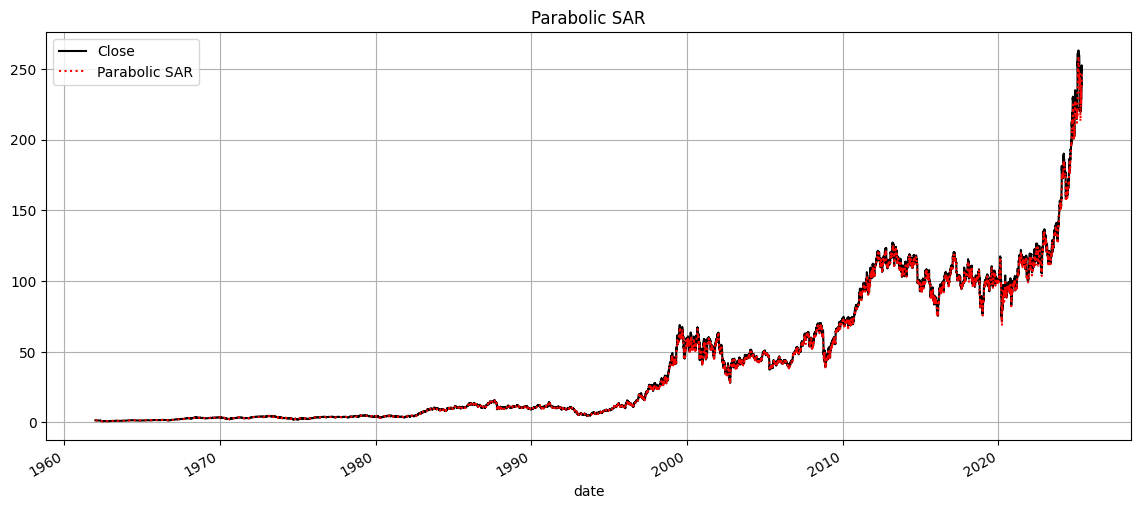

In [58]:
# Tính SAR
df_pd['SAR'] = calculate_parabolic_sar(df_pd['high'], df_pd['low'])

# Vẽ biểu đồ
plt.figure(figsize=(14,6))
df_pd['close'].plot(label='Close', color='black')
df_pd['SAR'].plot(label='Parabolic SAR', linestyle=':', color='red')
plt.title("Parabolic SAR")
plt.legend()
plt.grid(True)
plt.show()
